# Clandestine Runway Detection
This notebook presents a deep learning approach to detect clandestine or unauthorized runways in satellite imagery. Clandestine runways pose security risks, as they can be used for illegal activities such as unauthorized landings, smuggling, and other covert operations. The goal of this project is to identify and localize active clandestine runways in remote regions using high-resolution satellite data, making it easier for authorities and organizations to monitor and address these hidden threats.

## Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import re
import shutil
import toml
import json
import random
import datetime
from functools import partial

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from skimage.transform import resize
from rasterio.enums import Resampling

from scipy.interpolate import make_interp_spline

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import tensorflow as tf
import torch
from transformers import TFSegformerModel, TFSegformerDecodeHead, SegformerConfig

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import *
from src.model import DualSegformerClassifierModel, ClearMemoryCallback

2024-11-14 08:34:09.672986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 08:34:09.759263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 08:34:09.783874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 08:34:09.954461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 08:34:11.472516: W tensorflow/compiler/tf2

In [4]:
# check gpu device available
assert len(tf.config.experimental.list_physical_devices('GPU')) > 0, 'This notebook requires GPU to run!'

I0000 00:00:1731594856.588120  680647 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731594856.593302  680647 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731594856.593372  680647 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
# set notebook memory limit
tf.config.LogicalDeviceConfiguration(memory_limit=7500)
torch.cuda.set_per_process_memory_fraction(0.9)

In [6]:
SEED = 1234
set_seed(SEED)

Seed set to: 1234


## Constants

In [7]:
config = toml.load('./config.toml')
config.keys()

dict_keys(['data', 'params', 'output', 'patches'])

In [8]:
train_dir = config['data']['image_data']['train_image_dir']
test_dir = config['data']['image_data']['test_image_dir']
logs_dir = config['output']['logs_dir']

In [9]:
BATCH_SIZE = config['params']['model']['batch_size']
HEIGHT = config['params']['data']['height']
WIDTH = config['params']['data']['width']

## Load Data

### Helper Functions

In [10]:
def load_images(path):
    '''Loads data pairs of tif image and corresponding mask
    Parameters
    ----------
    path : str
        Path to folder containing raster-mask pairs
    Returns
    -------
    list of ndarrays
    '''
    # Fetch files
    images = [os.path.join(path, i) for i in os.listdir(path)]
    image_feature = [i for i in images if 'sdata' in i][0]
    image_target = [i for i in images if 'target' in i][0]

    # Read target mask
    with rio.open(image_target) as src:
        target_bounds = src.bounds
        arr_target = src.read( 
            out_shape = (256, 256), # output size hardcoded to 256 8 256
            resampling = Resampling.bilinear
        )
        arr_target = np.moveaxis(arr_target, 0, -1)
        
        # some non examples got corrupted during saving
        # pending new download fix..
        # the condition below manually fixes the problem
        if path[-1] == '0' and arr_target.sum() > 0:
            arr_target *= 0
        src.close()

    # Read image mask
    with rio.open(image_feature) as src2:
        arr_feature = src2.read(
            out_shape = (src2.count, 512, 512), # size hardcoded to segformer 512_512
            resampling = Resampling.nearest
        )
        arr_feature = np.moveaxis(arr_feature, 0, -1)
        src2.close()

    # delete vars to save memeory
    del images, image_feature, image_target
    
    return (arr_feature, arr_target)

In [11]:
def plot_sample_images(path, num_samples, cmap = 'Spectral_r', random_state = 1):
    '''
    Helper function to visualize samples
    Parameters
    path : str
        Path to folder containing image mask pairs.
    num_samples : int
        Number of samples to plot. Maximum of six (6).
    cmap : str
        Matplotlib cmap for visualization.
    random_state : int
        Random seed
    Returns
    -------
    None
    '''
    # clip number of samples
    num_samples = min(num_samples, 6)

    # set random state
    np.random.seed(random_state)

    # select samples
    samples = np.random.choice(path, num_samples, replace = False)
        
    # set figure
    fig, ax = plt.subplots(2, num_samples, figsize = (24, 6))

    # plot images
    for i in range(num_samples):
        img, targ = load_images(samples[i])
        img = np.clip(img[:, :, [2, 1, 0]] / 1000, 0, 1)       
        ax[0][i].imshow(img, cmap = cmap)
        ax[1][i].imshow(targ, cmap = 'gray')
        ax[0][i].axis('off')
        ax[1][i].axis('off')

## Load and view data

In [12]:
# load data from train download log
train_download_log = os.path.join(logs_dir, [i for i in os.listdir(logs_dir) if 'train_params.csv' in i][0])
train_shp = [os.path.join(train_dir, i) for i in os.listdir(train_dir) if 'geojson' in i][0]
train_shp

'./data/image/training/train.geojson'

In [13]:
# read competition train data
train_download_df = pd.read_csv(train_download_log)
train_gdf = gpd.read_file(train_shp)

# join to download log files
train_gdf = train_gdf.set_index('filename').join(train_download_df.set_index('name'))

# manually correct location with activo = 2 not caught in during download and too late to change at this point. 
train_gdf.loc[(train_gdf.Activo == 2) & (train_gdf.runway == 1), 'Activo'] = 1

# reformat active
# 0 = inactive, 1 = active, 2 = no runway
train_gdf['Activo'] = abs(2 - train_gdf.Activo)

In [14]:
# check if the error is fixed
m = train_gdf[train_gdf.Activo == 0]
m[m.id.duplicated(keep = False)]

,id,yr,largo,Activo,runway,x_offset,y_offset,output_dir,geometry,start_date,end_date,status
filename,,,,,,,,,,,,


#### Filter valid images
The download script could not retrieve suitable images from 2015. Filter out these points from the dataset

In [15]:
# select valid tbrain data
valid_train_df = train_gdf[train_gdf.status == 1]

In [16]:
# select train file directories from the dataframe
train_files = valid_train_df.apply(lambda x: x.output_dir, axis = 1).to_list()
train_target = valid_train_df['runway'].astype('float32')

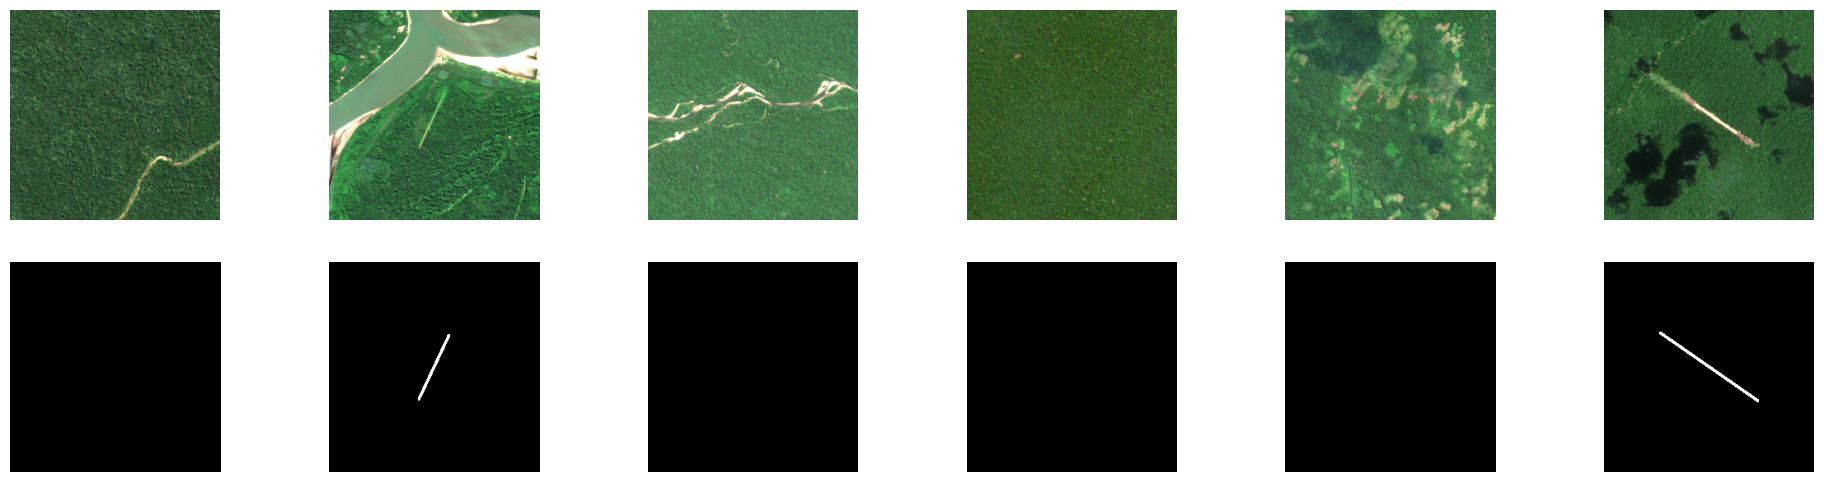

In [17]:
# visualize
plot_sample_images(train_files, 12, random_state = 6)

## Dataset Preparation

In [18]:
# split into train and validation sets
train, val, y_train, y_val = train_test_split(train_files, train_target, train_size = 0.80, random_state = 42)

### Define mapping functions over dataset

In [19]:
def load_data(path, activo):
    path = path.numpy().decode('utf-8')
    feature, target = load_images(path)
    target = target * activo
    year = int(path.split('_')[1])
    feature = tf.convert_to_tensor(tf.cast(feature, dtype = tf.float32))
    year = tf.convert_to_tensor(tf.cast(year, dtype = tf.float32))
    activo = tf.convert_to_tensor(tf.cast(activo, dtype = tf.float32))
    target = tf.convert_to_tensor(tf.cast(target, dtype = tf.uint8))
    del path
    return year, activo, feature, target

In [20]:
def remap_output_shape(*args):
    '''Enforces output shape to avoid output shape error in training'''
    args[0].set_shape(())
    args[1].set_shape(())
    args[2].set_shape((512, 512, 9)) # Hard coded values. Modify in future to be dynamic
    args[3].set_shape((256, 256, 1))
    return args[0], args[1], args[2], args[3]

In [21]:
def split_args(*args):
    '''Split into X and y'''
    return (args[0], args[2]), (args[1], args[3])

In [22]:
# There are paths similar to runways but with limited dataset, the model finds it hard to distinguish them.
# Synthetically generate paths using sum of sines. 

def draw_sine_paths(image, i_mean, i_std, max_freq, step, max_range = 50, offset = 20, data_format = 'channels_last'):
    '''Generates synthetic paths on images.
    Parameters
    ----------
    image : ndarray
        Image to draw on.
    i_mean : float
        Mean of paths/runway intensities.
    i_std : float
        Standard deviation of paths/runway intensities.
    max_freq : int
        Sine frequency
    step : int
        Step size between points on the wave
    max_range : int
        Max height range of waves/paths generated.
    offset : int
        Offset from reference axis
    data_format : str
        Data configuration of image. One of ('channels_first', 'channels_last')
    Returns
    -------
    np.ndarray
    '''
    
    # get axis to draw on
    if data_format == 'channels_last':
        axis = tf.random.uniform((), 0, 2, dtype = tf.int32)
    elif data_format == 'channels_first':
        axis = tf.random.uniform((), 1, 3, dtype = tf.int32)

    # define range and sizes
    size = tf.shape(image)[axis]
    t = tf.range(0, size + step, step)
    t = tf.expand_dims(t, 0)
    n_points = tf.shape(t)[1]

    # generate frequency, amplitude and phase
    freqs = tf.expand_dims(tf.linspace(0.1, max_freq, max_freq), 1)
    t_0 = tf.random.uniform((1, n_points), 0, size, dtype = tf.int32)
    A = tf.expand_dims(tf.linspace(1.0, 0.1, max_freq), 1)* tf.random.uniform((max_freq, 1), 1, 5)

    # create path points
    a = tf.reduce_sum(A * np.sin(2 * np.pi * freqs * tf.cast((t - t_0), tf.float32) / tf.cast(size, tf.float32)), axis = 0)
    
    # interpolate
    f = make_interp_spline(tf.squeeze(t), a)
    x = tf.range(0, size, 1, dtype = tf.int32)
    y = f(x)

    scaled_y = tf.cast((y - y.min()) / (y.max() - y.min()) * max_range, tf.int32) + offset
    
    image_2 = image.numpy().copy()
    channels = len(i_mean) - 1 # i_mean has one channel more than the image in the dataset.
    value = i_mean[:channels] + tf.random.normal((size, channels,), 0, 1) * i_std[:channels]
    
    if data_format == 'channels_last':
        if axis == 0:
            image_2[x, scaled_y, :channels] = value
        else: 
            image_2[scaled_y, x, :channels] = value
    elif data_format == 'channels_first':
        if axis == 1:
            image_2[:channels, x, scaled_y] = value
        else: 
            image_2[:channels, scaled_y, x, : ] = value

    del image, data_format, value, scaled_y, f, x, y, a, A, t_0, freqs, n_points, t, size, axis, max_range, offset, step, max_freq, i_mean, i_std

    return image_2

In [23]:
def random_translate(image, mask, max_translate = 256):
    """
    Apply random translation (shift) to the image and mask.
    
    Parameters
    ----------
    image : tf.constant
        Tensor of shape (height, width, channels)
    mask : tf.constant
        Tensor of shape (height, width, channels)
    max_translate : int
        The maximum number of pixels to translate (shift) in both x and y directions.
    
    Returns
    -------
    - Translated image and mask.
    """
    image_shape = tf.shape(image)
    mask_shape = tf.shape(mask)
    
    # Randomly determine the translation in x and y directions
    translate_x = tf.random.uniform([], -max_translate, max_translate, dtype=tf.int32)
    translate_y = tf.random.uniform([], -max_translate, max_translate, dtype=tf.int32)
    
    # Define translation shifts
    pad_x = tf.maximum(translate_x, 0)
    pad_y = tf.maximum(translate_y, 0)
    
    crop_x = tf.maximum(-translate_x, 0)
    crop_y = tf.maximum(-translate_y, 0)

    
    # Pad the image and mask
    image = tf.image.pad_to_bounding_box(image, pad_y, pad_x, image_shape[0] + abs(translate_y), image_shape[1] + abs(translate_x))
    mask = tf.image.pad_to_bounding_box(mask, pad_y // 2, pad_x // 2, mask_shape[0] + abs(translate_y//2), mask_shape[1] + abs(translate_x//2))

    # Crop back to the original size
    image = tf.image.crop_to_bounding_box(image, crop_y, crop_x, image_shape[0], image_shape[1])
    mask = tf.image.crop_to_bounding_box(mask, crop_y//2, crop_x//2, mask_shape[0], mask_shape[1])
    
    return image, mask

In [24]:
def augment_image_and_mask(year, active, image, mask, i_mean, i_std, max_freq, data_format):
    ''' Set of augmentation functions to pass to images and mask while training
    '''
    # Random Horizontal Flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random Vertical Flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random Rotation
    if tf.random.uniform(()) > 0.5:
        k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        mask = tf.image.rot90(mask, k=k)
        del k

    # Random Brightness
    image = tf.image.random_brightness(image, max_delta=0.3)  # Adjust brightness

    # Random Contrast
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)  # Adjust contrast

    # Draw Random Path
    if tf.random.uniform(()) > 0.5:
        step = np.random.randint(image.shape[1] // 16, image.shape[1] // 4)
        offset = np.random.randint(0, image.shape[1] // 2)
        max_range = np.random.randint(image.shape[1] // 8, image.shape[1] // 4)
        image = draw_sine_paths(
            image, i_mean = i_mean, i_std = i_std, 
            max_freq = max_freq, step = step, offset = offset, 
            max_range = max_range, data_format = data_format
        )
        del step, offset, max_range
        
    # Random Translate and Mask
    cond = tf.random.uniform(())
    if cond > 0.5:
        image, mask = random_translate(image, mask)

    del cond
    return year, active, image, mask


In [25]:
def calculate_runway_intensity_values(files):
    '''Extracts runway intesity form image files'''
    means = []
    sds = []
    # Loop through images and get all the mean and std.dev intensities
    for path in files:
        temp = [os.path.join(path, i) for i in os.listdir(path)]
        with rio.open(temp[0]) as src:
            sdata = src.read()
            src.close()
        with rio.open(temp[1]) as src2:
            targ = src2.read()
            targ = np.where(targ == 0, np.nan, targ)
            src2.close()
        sdata = sdata * targ
        means.append(np.nanmean(sdata, axis = (1, 2)))
        sds.append(np.nanstd(sdata, axis = (1, 2)))
    means = np.array(means).mean(axis = 0)
    sds = np.array(sds).mean(axis = 0)
    del path, files, temp, sdata
    return means, sds  

### Get runway intensities and augmentation functions

In [26]:
runway_files = [i for i in train_files if i[-1] != '0']
path_means, path_stds = calculate_runway_intensity_values(runway_files)

In [27]:
augment_function = partial(augment_image_and_mask, i_mean = path_means, i_std = path_stds, max_freq = 10, data_format = 'channels_last')

### Build Datasets

***Note***: With a small dataset, do not cache as this leads to overfitting on the training set.

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((train, y_train))
train_dataset = train_dataset.map(lambda x, y: tf.py_function(load_data, [x, y], Tout = [tf.float32, tf.float32, tf.float32, tf.uint8]))
train_dataset = train_dataset.map(remap_output_shape)
train_dataset = train_dataset.map(lambda w, x, y, z: tf.py_function(augment_function, [w, x, y, z], Tout = [tf.float32, tf.float32, tf.float32, tf.uint8]))
train_dataset = train_dataset.map(remap_output_shape)
train_dataset = train_dataset.map(split_args)
train_dataset = train_dataset.shuffle(32).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1731594864.023221  680647 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731594864.023408  680647 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731594864.023480  680647 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731594864.023790  680647 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731594864.023852  680647 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14

In [29]:
val_dataset = tf.data.Dataset.from_tensor_slices((val, y_val))
val_dataset = val_dataset.map(lambda x, y: tf.py_function(load_data, [x, y], Tout = [tf.float32, tf.float32, tf.float32, tf.uint8]))
val_dataset = val_dataset.map(remap_output_shape)
val_dataset = val_dataset.map(split_args)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [30]:
train_dataset.element_spec

((TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 512, 512, 9), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None)))

In [31]:
val_dataset.element_spec

((TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 512, 512, 9), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None)))

## Model

### Model Training

In [32]:
model_params = config['params']['model']
model_ckpt = model_params['model_checkpoint']
num_seg_labels = model_params['segmentation_num_classes']
num_classif_labels = model_params['classification_num_classes']
label2id = model_params['ids']['label2id']
id2label = model_params['ids']['id2label']

In [33]:
model = DualSegformerClassifierModel(
    pretrained_path = model_ckpt,
    input_size = (512, 512, 9),
    output_size = (HEIGHT, WIDTH),
    classifier_depth = 128,
    num_classif_labels = num_classif_labels,
    num_seg_labels = num_seg_labels,
    label2id = label2id,
    id2label = id2label
) 

Some layers from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 were not used when initializing TFSegformerModel: ['decode_head']
- This IS expected if you are initializing TFSegformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFSegformerModel were initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerModel for predictions without further training.
Some layers from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 were not used when

In [34]:
model.build([[None, 1], [None,512, 512, 9]])
model.summary()

Model: "tf_segformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  24196288  
 Layer)                                                          
                                                                 
Total params: 24196288 (92.30 MB)
Trainable params: 24196288 (92.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 512, 512, 9)       36        
 Normalization)                                                  
                                                                 
 image_prepocessor (Conv2D)  (None, 512, 512, 64)      5248      
                                                    

In [35]:
model.compile(
    loss = [['binary_crossentropy'], [tf.keras.losses.SparseCategoricalCrossentropy(reduction = 'sum')]],
    metrics = [['accuracy'], ['accuracy']],
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
)

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau('val_output_1_loss', patience = 10, factor = 0.1, min_delta = 400)
early_stopping = tf.keras.callbacks.EarlyStopping('val_output_1_loss', patience = 20, restore_best_weights = True)

In [ ]:
history = model.fit(train_dataset, validation_data = val_dataset, callbacks = [lr_plateau, early_stopping, ClearMemoryCallback()], epochs = 100)

Epoch 1/100


2024-11-14 08:41:27.715735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-14 08:41:35.181809: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
W0000 00:00:1731595295.392089  680834 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595295.462863  680834 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595295.465070  680834 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595295.467159  680834 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595295.469368  680834 gpu_timer.cc:114] Skipping the delay kernel, measu

116/117 [============================>.] - ETA: 0s - loss: 4816.9204 - output_1_loss: 3.0545 - output_2_loss: 4813.8662 - output_1_accuracy: 0.5216 - output_2_accuracy: 0.9956

W0000 00:00:1731595359.739839  680831 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595359.741039  680831 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595359.742324  680831 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595359.743437  680831 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595359.744491  680831 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595359.745607  680831 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595359.746710  680831 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595359.748406  680831 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731595359.749999  680831 gp

117/117 [==============================] - 124s 478ms/step - loss: 4809.3164 - output_1_loss: 3.0600 - output_2_loss: 4806.2568 - output_1_accuracy: 0.5193 - output_2_accuracy: 0.9955 - val_loss: 1504.9124 - val_output_1_loss: 1.3564 - val_output_2_loss: 1503.5562 - val_output_1_accuracy: 0.4407 - val_output_2_accuracy: 0.9980 - lr: 1.0000e-04
Epoch 2/100


2024-11-14 08:43:00.420704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 55s 389ms/step - loss: 1314.4019 - output_1_loss: 1.8487 - output_2_loss: 1312.5532 - output_1_accuracy: 0.5279 - output_2_accuracy: 0.9977 - val_loss: 1092.3689 - val_output_1_loss: 2.8242 - val_output_2_loss: 1089.5447 - val_output_1_accuracy: 0.4407 - val_output_2_accuracy: 0.9981 - lr: 1.0000e-04
Epoch 3/100
117/117 [==============================] - 56s 389ms/step - loss: 1093.0562 - output_1_loss: 3.6038 - output_2_loss: 1089.4525 - output_1_accuracy: 0.4764 - output_2_accuracy: 0.9978 - val_loss: 1119.9998 - val_output_1_loss: 2.6630 - val_output_2_loss: 1117.3364 - val_output_1_accuracy: 0.4407 - val_output_2_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 4/100


2024-11-14 08:44:52.118185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 56s 390ms/step - loss: 946.3666 - output_1_loss: 3.1186 - output_2_loss: 943.2484 - output_1_accuracy: 0.4678 - output_2_accuracy: 0.9979 - val_loss: 843.0208 - val_output_1_loss: 0.8877 - val_output_2_loss: 842.1329 - val_output_1_accuracy: 0.5593 - val_output_2_accuracy: 0.9982 - lr: 1.0000e-04
Epoch 5/100
117/117 [==============================] - 56s 389ms/step - loss: 875.8245 - output_1_loss: 2.5103 - output_2_loss: 873.3143 - output_1_accuracy: 0.4764 - output_2_accuracy: 0.9980 - val_loss: 1000.0304 - val_output_1_loss: 0.5546 - val_output_2_loss: 999.4758 - val_output_1_accuracy: 0.8305 - val_output_2_accuracy: 0.9977 - lr: 1.0000e-04
Epoch 6/100


2024-11-14 08:46:44.258813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 58s 399ms/step - loss: 792.5467 - output_1_loss: 2.6054 - output_2_loss: 789.9412 - output_1_accuracy: 0.4936 - output_2_accuracy: 0.9981 - val_loss: 836.0107 - val_output_1_loss: 0.9213 - val_output_2_loss: 835.0895 - val_output_1_accuracy: 0.5593 - val_output_2_accuracy: 0.9981 - lr: 1.0000e-04
Epoch 7/100
117/117 [==============================] - 59s 402ms/step - loss: 767.0748 - output_1_loss: 2.2635 - output_2_loss: 764.8113 - output_1_accuracy: 0.5150 - output_2_accuracy: 0.9981 - val_loss: 815.4798 - val_output_1_loss: 6.2538 - val_output_2_loss: 809.2261 - val_output_1_accuracy: 0.4407 - val_output_2_accuracy: 0.9983 - lr: 1.0000e-04
Epoch 8/100


2024-11-14 08:48:41.127141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 56s 384ms/step - loss: 734.4557 - output_1_loss: 1.7045 - output_2_loss: 732.7515 - output_1_accuracy: 0.6824 - output_2_accuracy: 0.9982 - val_loss: 963.6910 - val_output_1_loss: 1.9103 - val_output_2_loss: 961.7808 - val_output_1_accuracy: 0.7288 - val_output_2_accuracy: 0.9977 - lr: 1.0000e-04
Epoch 9/100
117/117 [==============================] - 59s 406ms/step - loss: 719.4837 - output_1_loss: 0.6978 - output_2_loss: 718.7859 - output_1_accuracy: 0.8069 - output_2_accuracy: 0.9981 - val_loss: 796.5417 - val_output_1_loss: 0.4424 - val_output_2_loss: 796.0994 - val_output_1_accuracy: 0.8305 - val_output_2_accuracy: 0.9980 - lr: 1.0000e-04
Epoch 10/100


2024-11-14 08:50:36.850103: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 58s 404ms/step - loss: 640.1846 - output_1_loss: 0.6661 - output_2_loss: 639.5183 - output_1_accuracy: 0.8455 - output_2_accuracy: 0.9982 - val_loss: 739.6104 - val_output_1_loss: 0.5592 - val_output_2_loss: 739.0513 - val_output_1_accuracy: 0.8814 - val_output_2_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 11/100
117/117 [==============================] - 61s 416ms/step - loss: 649.5276 - output_1_loss: 0.7491 - output_2_loss: 648.7784 - output_1_accuracy: 0.8412 - output_2_accuracy: 0.9983 - val_loss: 694.6083 - val_output_1_loss: 0.6067 - val_output_2_loss: 694.0017 - val_output_1_accuracy: 0.8136 - val_output_2_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 12/100


2024-11-14 08:52:36.298658: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 59s 400ms/step - loss: 582.6710 - output_1_loss: 0.3271 - output_2_loss: 582.3439 - output_1_accuracy: 0.8798 - output_2_accuracy: 0.9984 - val_loss: 593.7103 - val_output_1_loss: 0.5924 - val_output_2_loss: 593.1180 - val_output_1_accuracy: 0.8305 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 13/100
117/117 [==============================] - 59s 401ms/step - loss: 505.6913 - output_1_loss: 0.2849 - output_2_loss: 505.4064 - output_1_accuracy: 0.9142 - output_2_accuracy: 0.9985 - val_loss: 583.6385 - val_output_1_loss: 0.4726 - val_output_2_loss: 583.1660 - val_output_1_accuracy: 0.8475 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 14/100


2024-11-14 08:54:34.437937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 60s 414ms/step - loss: 505.9503 - output_1_loss: 0.2488 - output_2_loss: 505.7016 - output_1_accuracy: 0.9056 - output_2_accuracy: 0.9985 - val_loss: 587.3099 - val_output_1_loss: 0.4523 - val_output_2_loss: 586.8576 - val_output_1_accuracy: 0.8814 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 15/100


2024-11-14 08:55:34.848064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 60s 412ms/step - loss: 471.5757 - output_1_loss: 0.1826 - output_2_loss: 471.3931 - output_1_accuracy: 0.9442 - output_2_accuracy: 0.9986 - val_loss: 573.2368 - val_output_1_loss: 0.3866 - val_output_2_loss: 572.8502 - val_output_1_accuracy: 0.8814 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 16/100
117/117 [==============================] - 60s 406ms/step - loss: 491.1124 - output_1_loss: 0.2276 - output_2_loss: 490.8849 - output_1_accuracy: 0.9313 - output_2_accuracy: 0.9985 - val_loss: 574.2542 - val_output_1_loss: 0.4138 - val_output_2_loss: 573.8403 - val_output_1_accuracy: 0.8814 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 17/100


2024-11-14 08:57:34.455993: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 59s 401ms/step - loss: 481.1359 - output_1_loss: 0.1975 - output_2_loss: 480.9383 - output_1_accuracy: 0.9270 - output_2_accuracy: 0.9986 - val_loss: 582.8331 - val_output_1_loss: 0.3827 - val_output_2_loss: 582.4503 - val_output_1_accuracy: 0.8983 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 18/100


2024-11-14 08:58:34.460034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 60s 409ms/step - loss: 489.3315 - output_1_loss: 0.2011 - output_2_loss: 489.1304 - output_1_accuracy: 0.9356 - output_2_accuracy: 0.9985 - val_loss: 569.4464 - val_output_1_loss: 0.3234 - val_output_2_loss: 569.1230 - val_output_1_accuracy: 0.8983 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 19/100


2024-11-14 08:59:34.495022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 61s 412ms/step - loss: 442.6076 - output_1_loss: 0.1194 - output_2_loss: 442.4883 - output_1_accuracy: 0.9528 - output_2_accuracy: 0.9986 - val_loss: 582.1021 - val_output_1_loss: 0.2711 - val_output_2_loss: 581.8311 - val_output_1_accuracy: 0.9153 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 20/100


2024-11-14 09:00:34.830485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 60s 405ms/step - loss: 478.1777 - output_1_loss: 0.2162 - output_2_loss: 477.9614 - output_1_accuracy: 0.9442 - output_2_accuracy: 0.9985 - val_loss: 560.6882 - val_output_1_loss: 0.2859 - val_output_2_loss: 560.4023 - val_output_1_accuracy: 0.8983 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 21/100
117/117 [==============================] - 58s 402ms/step - loss: 452.5538 - output_1_loss: 0.2053 - output_2_loss: 452.3483 - output_1_accuracy: 0.9399 - output_2_accuracy: 0.9986 - val_loss: 560.8784 - val_output_1_loss: 0.3617 - val_output_2_loss: 560.5167 - val_output_1_accuracy: 0.8983 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-05
Epoch 22/100


2024-11-14 09:02:33.175796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 57s 396ms/step - loss: 467.4187 - output_1_loss: 0.1888 - output_2_loss: 467.2300 - output_1_accuracy: 0.9227 - output_2_accuracy: 0.9986 - val_loss: 558.6345 - val_output_1_loss: 0.2827 - val_output_2_loss: 558.3517 - val_output_1_accuracy: 0.8644 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-06
Epoch 23/100
117/117 [==============================] - 60s 405ms/step - loss: 454.7827 - output_1_loss: 0.0892 - output_2_loss: 454.6933 - output_1_accuracy: 0.9614 - output_2_accuracy: 0.9986 - val_loss: 559.3308 - val_output_1_loss: 0.2983 - val_output_2_loss: 559.0325 - val_output_1_accuracy: 0.8814 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-06
Epoch 24/100


2024-11-14 09:04:30.703426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 60s 398ms/step - loss: 466.8369 - output_1_loss: 0.1110 - output_2_loss: 466.7261 - output_1_accuracy: 0.9614 - output_2_accuracy: 0.9986 - val_loss: 564.5462 - val_output_1_loss: 0.3419 - val_output_2_loss: 564.2044 - val_output_1_accuracy: 0.8814 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-06
Epoch 25/100


2024-11-14 09:05:30.833448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


117/117 [==============================] - 59s 396ms/step - loss: 453.7849 - output_1_loss: 0.1401 - output_2_loss: 453.6449 - output_1_accuracy: 0.9442 - output_2_accuracy: 0.9986 - val_loss: 569.1536 - val_output_1_loss: 0.3071 - val_output_2_loss: 568.8463 - val_output_1_accuracy: 0.8814 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-06
Epoch 26/100
117/117 [==============================] - 60s 409ms/step - loss: 442.7802 - output_1_loss: 0.1210 - output_2_loss: 442.6592 - output_1_accuracy: 0.9571 - output_2_accuracy: 0.9986 - val_loss: 565.4594 - val_output_1_loss: 0.3281 - val_output_2_loss: 565.1312 - val_output_1_accuracy: 0.8814 - val_output_2_accuracy: 0.9986 - lr: 1.0000e-06
Epoch 27/100


2024-11-14 09:07:29.606107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indual_segformer_classifier_model/tf_segformer_decode_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 57/117 [=============>................] - ETA: 22s - loss: 426.7024 - output_1_loss: 0.0648 - output_2_loss: 426.6375 - output_1_accuracy: 0.9912 - output_2_accuracy: 0.9987

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
ax[0].plot(history.history['output_1_loss'], label = 'clf_train_loss')
ax[0].plot(history.history['val_output_1_loss'], label = 'clf_val_loss')

ax[1].plot(history.history['output_2_loss'], label = 'seg_train_loss')
ax[1].plot(history.history['val_output_2_loss'], label = 'seg_val_loss')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
ax[0].plot(history.history['output_1_accuracy'], label = 'clf_train_accuracy')
ax[0].plot(history.history['val_output_1_accuracy'], label = 'clf_val_accuracy')

ax[1].plot(history.history['output_2_accuracy'], label = 'seg_train_accuracy')
ax[1].plot(history.history['val_output_2_accuracy'], label = 'seg_val_accuracy')

### View Validation Data

In [ ]:
results = model.predict(val_dataset)

In [ ]:
seg_thresh = 0.3
classif_thresh = 0.3

In [ ]:
predicted_images = (results[1][:, :, :, 1] > seg_thresh).astype(int)
predicted_labels = (results[0] > classif_thresh).astype(int)

In [ ]:
ground_truth_images = []
ground_truth_labels = []
ground_truth_image_labels = []
for i in val_dataset.as_numpy_iterator():
    ground_truth_images.append(i[0][1])
    ground_truth_labels.extend(list(i[1][0].astype(int)))
    ground_truth_image_labels.append(i[1][1])
ground_truth_image_labels = np.concatenate(ground_truth_image_labels)
ground_truth_images = np.concatenate(ground_truth_images)

#### Localisation metrics

In [ ]:
labels = ['non_runway', 'runway']
print(classification_report(ground_truth_labels, predicted_labels, target_names = labels))

In [ ]:
ConfusionMatrixDisplay.from_predictions(ground_truth_labels, predicted_labels, labels = labels, normalize = 'all');

#### Segmentation metrics

The transformer libraries use tf_keras which doesn't have IOU and BinaryIOU metrics implemented. 

In [ ]:
def iou_sklearn(y_true, y_pred, num_classes = 2):
    '''Computes IOU over predictions'''
    iou_per_class = []
    
    for cls in range(num_classes):
        # Create binary masks for the current class
        y_true_cls = (y_true == cls).astype(np.int32)
        y_pred_cls = (y_pred == cls).astype(np.int32)
        
        # Calculate intersection and union
        intersection = np.logical_and(y_true_cls, y_pred_cls).sum()
        union = np.logical_or(y_true_cls, y_pred_cls).sum()
        
        # Handle the case of no true/predicted samples in a class
        if union == 0:
            iou = float('nan')  # Or 0, depending on how you prefer to handle
        else:
            iou = intersection / union
        
        iou_per_class.append(iou)
    
    # Compute the mean IoU across all classes, ignoring NaNs
    mean_iou = np.nanmean(iou_per_class)
    return mean_iou


In [ ]:
print(iou_sklearn(ground_truth_image_labels, predicted_images))

#### View predictions

In [ ]:
nrows = 4
ncols = 6
fig, ax = plt.subplots(nrows, ncols, figsize = (15, 3))
sample = np.random.choice(np.arange(0, len(ground_truth_images)), ncols, replace = False)
for i in range(n_cols):
    ax[0][i].imshow(ground_truth_images[i, :, :, :3] / 1000)
    ax[0][i].axis('off')
    ax[1][i].imshow(predicted_images[i], cmap = 'gray', alpha = 1)
    ax[1][i].axis('off')
    ax[2][i].imshow(ground_truth_image_labels[i], cmap = 'gray', alpha = 1)
    ax[2][i].axis('off')

### Save Model

In [ ]:
model_name = f"{datetime.datetime.now().strftime('%Y%m%dT%H%M')_dualsegformerclassifier_b2_512_512"
model_name = os.path.join(config['output']['predictions_dir'], model_name)
model.save_model(model_name)

In [ ]:
gc.collect()

## Inference

In [ ]:
test_shp = [os.path.join(test_dir, i) for i in os.listdir(test_dir) if 'geojson' not in i]
test_file = [os.path.join(test_dir, i) for i in os.listdir(test_dir) if 'geojson' in i][0]

In [ ]:
test_gdf = gpd.read_file(test_file)

In [ ]:
map_dict = {}
for i in test_gdf.filename:
    map_dict[i] = [j for j in test_shp if i in j][0]

In [ ]:
test_gdf['height'] = ((test_gdf.MAXY - test_gdf.MINY) // 10).astype(int)
test_gdf['width'] = ((test_gdf.MAXX - test_gdf.MINX) // 10).astype(int)
test_gdf['filepath'] = test_gdf.filename.map(map_dict)
test_gdf['tile_name'] = test_gdf.filename.apply(lambda x: x[-5:])
test_gdf.head()

In [ ]:
def get_predictors(path, size):
    with rio.open(path) as src:
        image = src.read(out_shape = size)
        image = np.moveaxis(image, 0, -1)
        # The submission file row_column is transposed
        # The function below transposes the image to match the submission file.
        image = np.transpose(image, axes =(1, 0, 2))
    year = int(os.path.basename(path).split('_')[1])
    return year, image

In [ ]:
import numpy as np

def patch_based_inference(model, image, year, patch_size, overlap_size, classif_confidence = 0.3, seg_confidence = 0.3):
    """
    Perform patch-basaed inference with overlap on the image.
    
    Parameters
    ----------
    model : tf.keras.Model
        Dual segmentation classifier model.
    image : np.ndarray
        Input image
    year: int
        Year of observation.
    patch_size: int
        Size of each patch.
    overlap_size : int 
        Overlap between patches.
    
    Returns
    -------
    nd.array: Reconstructed output after patch-based inference.
    """
    
    H, W, C = image.shape
    stride = patch_size - overlap_size
    
    # Number of patches along height and width
    num_patches_h = (H - overlap_size) // stride
    num_patches_w = (W - overlap_size) // stride
    
    # Empty array to hold predictions
    prediction_map = np.zeros((image.shape[0], image.shape[1]))
    count_map = np.zeros((image.shape[0], image.shape[1]))  # To keep track of the overlaps
    year = tf.expand_dims(year, 0)
    
    for i in range(0, H, stride):
        for j in range(0, W, stride):

            if i + patch_size > H:
                i_start = H - patch_size  # Move back to fit the patch within the image
            else:
                i_start = i

            if j + patch_size > W:
                j_start = W - patch_size  # Move back to fit the patch within the image
            else:
                j_start = j
                
            # Extract patch
            patch = image[i_start:i_start + patch_size, j_start:j_start + patch_size, :]
            
            # Model inference on the patch
            patch = tf.image.resize(np.expand_dims(patch, axis=0), size = (512, 512)) # hard coded - resize to model input size
            is_runway, patch_prediction = model.predict([year, patch])
            is_runway = (is_runway > classif_confidence).astype(int)
            patch_prediction = (patch_prediction[:, :, :, 1].squeeze() > seg_confidence).astype(int)
            
            # Calculate where to place this patch's prediction in the final image
            pred_h_start = i_start
            pred_h_end = i_start + patch_size
            pred_w_start = j_start
            pred_w_end = j_start + patch_size
            # print(is_runway)
            
            # Add the patch prediction to the prediction map
            if is_runway:
                print('found')
                prediction_map[pred_h_start:pred_h_end, pred_w_start:pred_w_end] =  prediction_map[pred_h_start:pred_h_end, pred_w_start:pred_w_end] + patch_prediction
            else:
                pass
                
            # average out predictions
            # use a voting based inference. 
            # i.e In overlapping regions, if a pixel is classified as positive at least once, it is marked as positive.
            prediction_map = (prediction_map > 0).astype(int)
     
    return prediction_map


In [ ]:
# This function is used in earlier iterations where prediction confidence was very low
def thresholding(img, confidence = 0.3):
    '''Threshold soft predictions to find areas of interest'''
    otsu_thresh = skimage.filters.threshold_otsu(img, nbins = 1000)
    print(otsu_thresh, img.dtype)
    thresh = max(otsu_thresh, np.quantile(img, 0.95), confidence)
    img = (img > thresh).astype(int)
    return img

In [ ]:
def straighten_runway_lines(img, min_gap = 50, hough_threshold = 25):
    # get potential runway lines
    # # skeletonize to remove noise
    # # use hough transform to get lines
    # # draw lines on canvas
    img = skimage.morphology.dilation(img, skimage.morphology.disk(3))
    img = skimage.morphology.skeletonize(img, method = 'lee') + skimage.morphology.skeletonize(img, method = 'zhang')
    lines = skimage.transform.probabilistic_hough_line(img, threshold = hough_threshold,  line_gap = min_gap)

    # draw new lines
    img_new = np.zeros_like(img)
    for line in lines:
       p0, p1 = line
       rr, cc = skimage.draw.line(p0[1], p0[0], p1[1], p1[0])
       img_new[rr, cc] = 1

    # widen runways, fill holes and remove small objects
    img = skimage.morphology.dilation(img_new, skimage.morphology.disk(2))
    img = skimage.morphology.binary_closing(img, skimage.morphology.disk(6))
    img = skimage.morphology.remove_small_objects(img, 10)

    return img
    

In [ ]:
def filter_non_runways(img, min_length = 40, max_length = 250, min_eccentricity = 0.99, max_circularity = 0.25):
    label_image = skimage.measure.label(img, connectivity = 2)
    filtered_image = np.zeros(label_image.shape, dtype=bool)
    for region in skimage.measure.regionprops(label_image):
        # Calculate properties: eccentricity, solidity, etc.
        eccentricity = region.eccentricity  # How elongated the shape is (1 = line, 0 = circle)
        length = region.axis_major_length
        circularity = 2 * np.pi * region.area / (region.perimeter ** 2)
    
        # Filtering condition: Adjust these values based on desired filtering
        if length <= max_length and length >= min_length and eccentricity >= min_eccentricity and circularity <= max_circularity:
            filtered_image[region.coords[:, 0], region.coords[:, 1]] = 1   
    return filtered_image

In [ ]:
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops

def generate_pred_df(img, name):
    '''Generate prediction dataframe frome each test image'''
    
    # Label connected components in the binary image
    labeled_img = label(img)
    
    # List to store data for each detected runway
    data = []

    # use skimage to identify regions of positive segmentation
    # for each region, build a 20 pixels buffer around its bounds
    # add the buffered region to a dataframe
    for region in regionprops(labeled_img):
        # Get the bounding box of the region (min_row, min_col, max_row, max_col)
        min_row, min_col, max_row, max_col = region.bbox
        
        # Apply a 20-pixel buffer around the bounding box
        min_row = max(min_row - 20, 0)
        max_row = min(max_row + 20, img.shape[0] - 1)
        min_col = max(min_col - 20, 0)
        max_col = min(max_col + 20, img.shape[1] - 1)
        
        # Create a mask for the buffered region
        buffer = np.zeros_like(img, dtype=int)
        buffer[min_row:max_row+1, min_col:max_col+1] = 1
        
        # Extract indices within the buffered region where the original image has detections
        indices = np.where(buffer == 1)
        values = img[indices]
        
        # Generate tile_row_column names for this buffered region
        names = [f'Tileaoi_{name}_{i}_{j}' for i, j in zip(indices[0], indices[1])]
        
        # Append data for this runway region to the list
        data.extend(zip(names, values.astype(int)))
    
    # Combine all runway data into a single DataFrame
    df = pd.DataFrame(data, columns=['tile_row_column', 'label'])
    return df


In [ ]:
def parse_submission(df):
    '''Parse submission to reduce file size'''
    df_1 = df[df.label == 1]
    df_2 = df[df.label == 0]
    df_2 = df_2.sample(n = 200000 - len(df_1), replace = False)

    df = pd.concat([df_1, df_2])

    df = df.sample(frac = 1, replace = False).reset_index(drop = True)
    return df

In [ ]:
def create_submission_file(model, df, patch_size = 256, overlap_size = 128, classif_confidence = 0.3, seg_confidence = 0.3, straighten_runways = False, filter_runways = False, min_gap = 25, hough_threshold = 25):
    # submission_file = pd.DataFrame(columns = ['tile_row_column', 'label'])
    submission_files = []
    predictions = []
    images = []
    for idx, row in df.iterrows():
        print(f'Generating predictions for {row.filepath}')
        print('-----------------------------------------')
        # get image_shape
        height = row.height
        width = row.width
        print('height :', height, ', width :', width)
        
        # generate years and path
        year, arr = get_predictors(row.filepath, size = (height, width))
        
        # generate test df
        pred = patch_based_inference(model, arr, year, patch_size, overlap_size, classif_confidence, seg_confidence)
        
        # post_process
        pred = pred * (arr[:, :, 8] <= 4) # get only vegetation and cloudless areas
       
        if straighten_runways:
            pred = thresholding(pred, confidence = seg_confidence)
            pred = straighten_runway_lines(pred, min_gap = min_gap, hough_threshold = hough_threshold)
        if filter_runways:
            pred = filter_non_runways(pred)

        # generate predictions
        pred_df = generate_pred_df(pred, name = row.tile_name)

        # append
        submission_files.append(pred_df)
        predictions.append(pred)
        images.append(arr)
        
        print('-----------------------------------------')
        
    # create submission file
    submission_file = pd.concat(submission_files)
    return submission_file, predictions, images

In [ ]:
%%time
submission_file, predictions, images = create_submission_file(model, test_gdf, classif_confidence = 0.3, seg_confidence = 0.3)

In [ ]:
submission_file_reduced.label.sum()

In [ ]:
plt.figure(figsize = (8, 8))
dir = model_name + '_images'
os.makedirs(dir)
for i in range(len(images)):
    plt.imshow(images[i][:, :, [0, 1, 2]] / 1000)
    plt.imshow(predictions[i], alpha = 0.4, cmap = 'gray');
    plt.axis('off');
    plt.tight_layout();   
    plt.savefig(os.path.join(dir, f'{i+1}.jpg'), dpi = 300); 
    plt.close();

In [ ]:
plt.figure(figsize = (8, 8))
n = 1
plt.imshow(images[n][:, :, [0, 1, 2]] / 1000)
plt.imshow(predictions[n], alpha = 0.4, cmap = 'gray');
predictions[n].shape

In [ ]:
# save submission file
submission_file.to_csv(os.path.join(config['output']['prediction_dir'], 'submission.csv'), index = False)